In [113]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

blinks = pd.read_csv("sample-data/blinks.csv")
fixations = pd.read_csv("sample-data/fixations.csv")
saccades = pd.read_csv("sample-data/saccades.csv")
gaze_positions = pd.read_csv("sample-data/gaze_positions.csv")

# test to see its working
print(blinks.head())

   blink id  start timestamp [ns]   end timestamp [ns]  duration [ms]
0         1   1747308624362212864  1747308624622460928     260.248064
1         2   1747308627605311744  1747308627795434752     190.123008
2         3   1747308650396380928  1747308650681753856     285.372928
3         4   1747308654325099776  1747308654705485824     380.386048
4         5   1747308663894022912  1747308664114145792     220.122880


In [114]:
#  reusable function to find best number of components for GMM
def select_best_gmm(X_scaled, max_components=6):
    bic_scores = []
    aic_scores = []
    n_range = range(1, max_components + 1)

    for n in n_range:
        gmm = GaussianMixture(n_components=n, random_state=42)
        gmm.fit(X_scaled)
        bic_scores.append(gmm.bic(X_scaled))
        aic_scores.append(gmm.aic(X_scaled))

    plt.plot(n_range, bic_scores, label='BIC', marker='o')
    plt.plot(n_range, aic_scores, label='AIC', marker='o')
    plt.xlabel('Number of Components')
    plt.ylabel('Score')
    plt.title('Model Selection: BIC & AIC')
    plt.legend()
    plt.show()

    best_n = n_range[bic_scores.index(min(bic_scores))]
    print(f"Optimal number of components (lowest BIC): {best_n}")
    return best_n

##### Blinks

In [115]:
# inter-blink interval: time duration between two consecutive blinks; the length of time the eyelids are open between blinks
# sorting by timestamp (but maybe redundant)
blinks = blinks.sort_values(by='start timestamp [ns]')
blinks['IBI [ms]'] = blinks['start timestamp [ns]'].diff() / 1e6  # convert ns → ms just to keep consistent

# strip unnecessary values and make a standalone dataframe we can safely modify 
blink_features = blinks[['duration [ms]', 'IBI [ms]']].dropna().copy()
blink_features['event_type'] = 'blink'

# scale
scaler = StandardScaler()
blink_scaled = scaler.fit_transform(blink_features[['duration [ms]', 'IBI [ms]']])

In [116]:
# Gaussian Mixture Model (GMM) clustering
# components 2 because so little data, random state is just my Blandford number lol
gmm = GaussianMixture(n_components=2, random_state=35)
blink_features['cluster'] = gmm.fit_predict(blink_scaled)

# check it works
print(blink_features['cluster'].value_counts())

cluster
1    10
0     4
Name: count, dtype: int64


##### Fixations

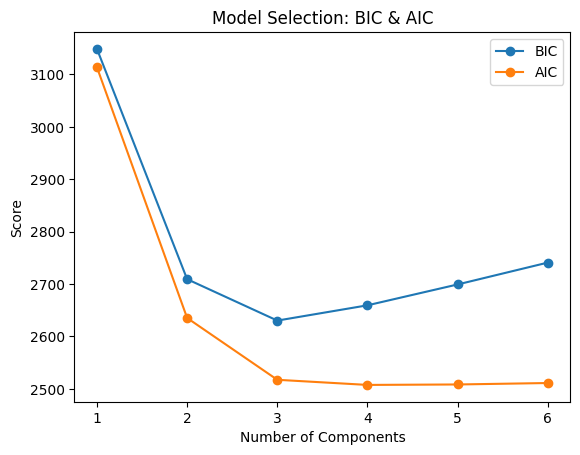

Optimal number of components (lowest BIC): 3


In [117]:
# including x and y here to later calculate spatial drift which could indicate fatigue/time
fixation_features = fixations[[
    'duration [ms]', 
    'fixation x [px]', 
    'fixation y [px]']].dropna().copy()
fixation_features['event_type'] = 'fixation'

# scale
fixation_scaled = scaler.fit_transform(fixation_features[['duration [ms]', 'fixation x [px]', 'fixation y [px]']])

# Run BIC (Bayesian Information Criterion) test to see number of components for cluster 
best_n = select_best_gmm(fixation_scaled, max_components=6)

In [118]:
# clustering, components chosen based on BIC
gmm = GaussianMixture(n_components=3, random_state=35)
fixation_features['cluster'] = gmm.fit_predict(fixation_scaled)

# check it works
print(fixation_features['cluster'].value_counts())

cluster
2    170
0    135
1     59
Name: count, dtype: int64


calculating spatial drift to (hopefully) indicate fatigue from fixation coordinates

In [119]:
# Add timestamp ONLY for temporal drift calculation
fixation_temp = fixations[
    ['start timestamp [ns]', 'fixation x [px]', 'fixation y [px]']
].dropna().copy()

# Sort just in case the CSV is out of order
fixation_temp = fixation_temp.sort_values(by='start timestamp [ns]')

# Compute rolling dispersion over a window of 10 fixations
fixation_temp['x_dispersion'] = fixation_temp['fixation x [px]'].rolling(window=10).std()
fixation_temp['y_dispersion'] = fixation_temp['fixation y [px]'].rolling(window=10).std()

# Combine for total spatial drift (Euclidean std)
fixation_temp['spatial_drift'] = (
    fixation_temp['x_dispersion']**2 + fixation_temp['y_dispersion']**2
)**0.5

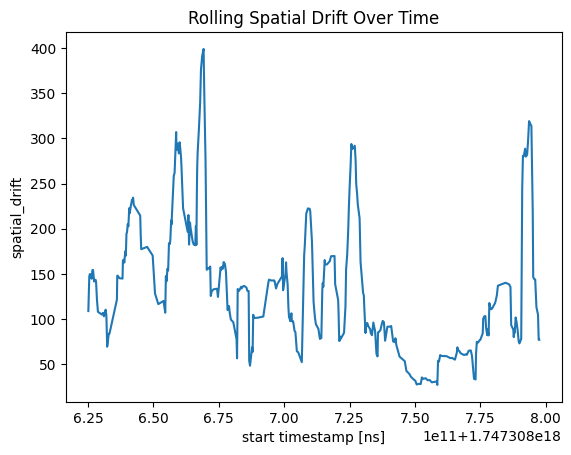

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(data=fixation_temp, x='start timestamp [ns]', y='spatial_drift')
plt.title("Rolling Spatial Drift Over Time")
plt.show()

##### Saccades

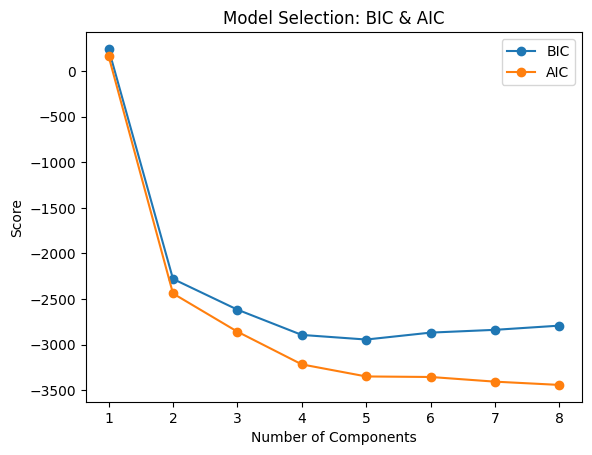

Optimal number of components (lowest BIC): 5


In [121]:
saccades_features = saccades[['duration [ms]', 'amplitude [px]', 'amplitude [deg]', 'mean velocity [px/s]', 'peak velocity [px/s]']].dropna().copy()
saccades_features['event_type'] = 'saccade'

# scale
saccades_scaled = scaler.fit_transform(saccades_features[['duration [ms]', 'amplitude [px]', 'amplitude [deg]', 'mean velocity [px/s]', 'peak velocity [px/s]']])

# BIC test
best_n = select_best_gmm(saccades_scaled, max_components=8)

In [122]:
# clustering, components chosen based on BIC
gmm = GaussianMixture(n_components=5, random_state=35)
saccades_features['cluster'] = gmm.fit_predict(saccades_scaled)

##### Gaze Positions

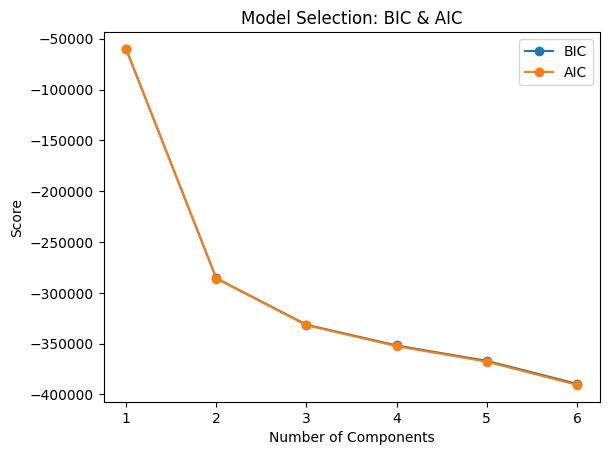

Optimal number of components (lowest BIC): 6


In [123]:
# using all features of gaze positions csv
gaze_features = gaze_positions[[
    'timestamp [ns]',
    'gaze x [px]', 
    'gaze y [px]', 
    'azimuth [deg]', 
    'elevation [deg]'
]].dropna().copy()
gaze_features['event_type'] = 'gaze-position'

# scale
scaler = StandardScaler()
gaze_scaled = scaler.fit_transform(gaze_features.drop(columns='event_type'))

# BIC test
best_n = select_best_gmm(gaze_scaled, max_components=6)

In [124]:
# clustering
gmm = GaussianMixture(n_components=5, random_state=35)
gaze_features['cluster'] = gmm.fit_predict(gaze_scaled)

# check it works
print(gaze_features['cluster'].value_counts())

cluster
4    14574
3    12892
0     3613
2     3385
1      975
Name: count, dtype: int64


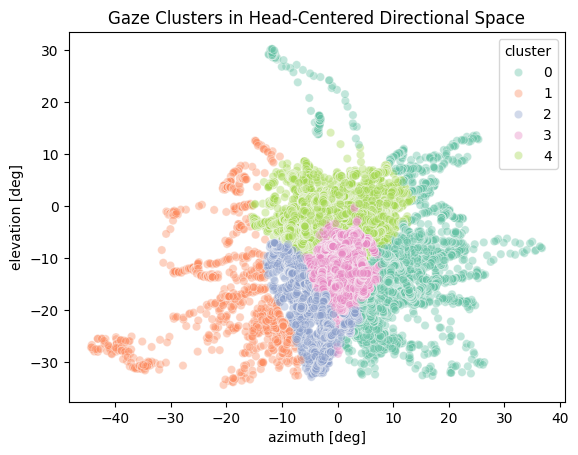

In [125]:
# difference between clusters for gaze positions
gaze_features.groupby('cluster')[['gaze x [px]', 'gaze y [px]', 'azimuth [deg]', 'elevation [deg]']].mean()

sns.scatterplot(
    data=gaze_features,
    x='azimuth [deg]',
    y='elevation [deg]',
    hue='cluster',
    palette='Set2',
    alpha=0.4
)
plt.title("Gaze Clusters in Head-Centered Directional Space")
plt.show()

## Analysis & Plots

In [126]:
# verify we have event type, cluster, and timestamps in order
print("gaze_features columns:", gaze_features.columns)
print("fixation_features columns:", fixation_features.columns)
print("saccades_features columns:", saccades_features.columns)

gaze_features columns: Index(['timestamp [ns]', 'gaze x [px]', 'gaze y [px]', 'azimuth [deg]',
       'elevation [deg]', 'event_type', 'cluster'],
      dtype='object')
fixation_features columns: Index(['duration [ms]', 'fixation x [px]', 'fixation y [px]', 'event_type',
       'cluster'],
      dtype='object')
saccades_features columns: Index(['duration [ms]', 'amplitude [px]', 'amplitude [deg]',
       'mean velocity [px/s]', 'peak velocity [px/s]', 'event_type',
       'cluster'],
      dtype='object')


In [127]:
print(gaze_features.columns)

Index(['timestamp [ns]', 'gaze x [px]', 'gaze y [px]', 'azimuth [deg]',
       'elevation [deg]', 'event_type', 'cluster'],
      dtype='object')


In [ ]:
# create timelines and merge
gaze_timeline = gaze_features[['timestamp [ns]', 'event_type', 'cluster']]
fixation_features['timestamp [ns]'] = fixations['start timestamp [ns]']  # make timestamps = to start timestamp so it stops errors
fixation_timeline = fixation_features[['timestamp [ns]', 'event_type', 'cluster']]
saccades_features['timestamp [ns]'] = saccades['start timestamp [ns]']  # make timestamps = to start timestamp so it stops errors
saccade_timeline = saccades_features[['timestamp [ns]', 'event_type', 'cluster']]

# make overall timeline
timeline = pd.concat([gaze_timeline, fixation_timeline, saccade_timeline], ignore_index=True)
# put it in chronological order 
timeline = timeline.sort_values(by='timestamp [ns]').reset_index(drop=True)
# print head & value counts to check it works
print(timeline.head())
print(timeline.event_type.value_counts())

        timestamp [ns]     event_type  cluster
0  1747308620788991829  gaze-position        4
1  1747308620793991829  gaze-position        4
2  1747308620798990829  gaze-position        4
3  1747308620803998829  gaze-position        4
4  1747308620808991829  gaze-position        4
event_type
gaze-position    35439
fixation           364
saccade            363
Name: count, dtype: int64


In [132]:
# make time in seconds so its more readable
timeline['time_s'] = (timeline['timestamp [ns]'] - timeline['timestamp [ns]'].iloc[0]) / 1e9

#### Gaze Analysis

In [133]:
gaze_only = timeline[timeline['event_type'] == 'gaze-position'].copy()

# detect changes in cluster, could indicate state change (e.g. focused, visual search, etc.)
gaze_only['prev_cluster'] = gaze_only['cluster'].shift()
gaze_only['new_state'] = gaze_only['cluster'] != gaze_only['prev_cluster']
gaze_only['state_id'] = gaze_only['new_state'].cumsum()

# summarize states
gaze_state_summary = gaze_only.groupby('state_id').agg({
    'cluster': 'first',
    'time_s': ['min', 'max']
}).reset_index()

# clean up column names
gaze_state_summary.columns = ['state_id', 'cluster', 'start_s', 'end_s']
gaze_state_summary['duration_s'] = gaze_state_summary['end_s'] - gaze_state_summary['start_s']

# print state summary to check it works
print(gaze_state_summary)

     state_id  cluster     start_s       end_s  duration_s
0           1        4    0.000000    1.856618    1.856618
1           2        2    1.861610    2.226982    0.365372
2           3        4    2.231982    3.192849    0.960867
3           4        0    3.197980    3.217974    0.019994
4           5        2    3.222974    3.408097    0.185123
..        ...      ...         ...         ...         ...
557       558        0  173.977974  174.007973    0.029999
558       559        3  174.012973  174.133099    0.120126
559       560        0  174.138099  174.138099    0.000000
560       561        3  174.143113  175.644473    1.501360
561       562        0  175.649472  177.366097    1.716625

[562 rows x 5 columns]


In [134]:
# calculate percentage of each cluster

total_time = gaze_state_summary['duration_s'].sum()

# Group by cluster and sum durations
gaze_cluster_durations = gaze_state_summary.groupby('cluster')['duration_s'].sum()

# Calculate percentage
gaze_cluster_percentages = (gaze_cluster_durations / total_time) * 100

# Convert to DataFrame for readability
gaze_cluster_percentages = gaze_cluster_percentages.reset_index()
gaze_cluster_percentages.columns = ['cluster', 'percent_time']
gaze_cluster_percentages = gaze_cluster_percentages.sort_values('percent_time', ascending=False)

# print to check it works
print(gaze_cluster_percentages)

   cluster  percent_time
4        4     41.380351
3        3     36.552239
0        0     10.091913
2        2      9.257372
1        1      2.718125


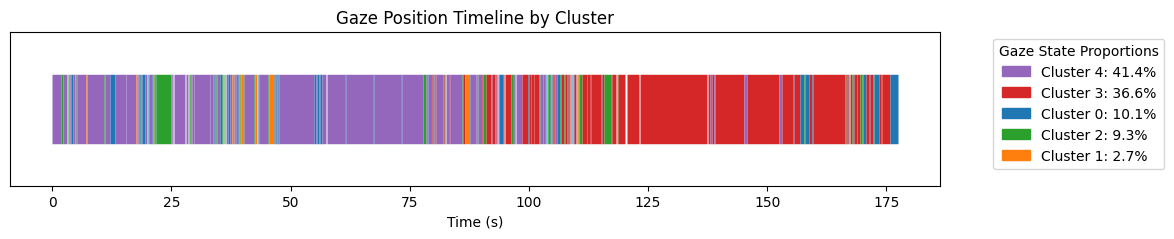

In [136]:
# plot gaze states over time
plt.figure(figsize=(12, 2))
for _, row in gaze_state_summary.iterrows():
    plt.hlines(1, row['start_s'], row['end_s'], colors=f'C{int(row["cluster"])}', linewidth=50)

# Build legend handles
handles = [
    mpatches.Patch(color=f'C{int(row.cluster)}', label=f"Cluster {int(row.cluster)}: {row.percent_time:.1f}%")
    for row in gaze_cluster_percentages.itertuples()
]

plt.legend(handles=handles, title='Gaze State Proportions', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Time (s)")
plt.yticks([])
plt.title("Gaze Position Timeline by Cluster")
plt.show()

#### Fixation Analysis

In [137]:
fixation_only = timeline[timeline['event_type'] == 'fixation'].copy()

# detect changes in cluster, could indicate state change (e.g. focused, visual search, etc.)
fixation_only['prev_cluster'] = fixation_only['cluster'].shift()
fixation_only['new_state'] = fixation_only['cluster'] != fixation_only['prev_cluster']
fixation_only['state_id'] = fixation_only['new_state'].cumsum()

# summarize states
fixation_state_summary = fixation_only.groupby('state_id').agg({
    'cluster': 'first',
    'time_s': ['min', 'max']
}).reset_index()

# clean up column names
fixation_state_summary.columns = ['state_id', 'cluster', 'start_s', 'end_s']
fixation_state_summary['duration_s'] = fixation_state_summary['end_s'] - fixation_state_summary['start_s']

# print state summary to check it works
print(fixation_state_summary)

     state_id  cluster     start_s       end_s  duration_s
0           1        0    0.124999    0.635495    0.510496
1           2        1    0.910742    0.910742    0.000000
2           3        0    1.876735    1.876735    0.000000
3           4        2    2.277106    2.277106    0.000000
4           5        1    2.422230    2.422230    0.000000
..        ...      ...         ...         ...         ...
187       188        0  174.438348  174.438348    0.000000
188       189        2  174.728598  174.728598    0.000000
189       190        0  174.908848  175.664472    0.755624
190       191        2  176.275097  176.525347    0.250250
191       192        0  176.740483  176.740483    0.000000

[192 rows x 5 columns]


In [138]:
total_time = fixation_state_summary['duration_s'].sum()

# Group by cluster and sum durations
fixation_cluster_durations = fixation_state_summary.groupby('cluster')['duration_s'].sum()

# Calculate percentage
fixation_cluster_percentages = (fixation_cluster_durations / total_time) * 100

# Convert to DataFrame for readability
fixation_cluster_percentages = fixation_cluster_percentages.reset_index()
fixation_cluster_percentages.columns = ['cluster', 'percent_time']
fixation_cluster_percentages = fixation_cluster_percentages.sort_values('percent_time', ascending=False)

# print to check it works
print(fixation_cluster_percentages)

   cluster  percent_time
1        1     36.191144
0        0     32.796101
2        2     31.012754


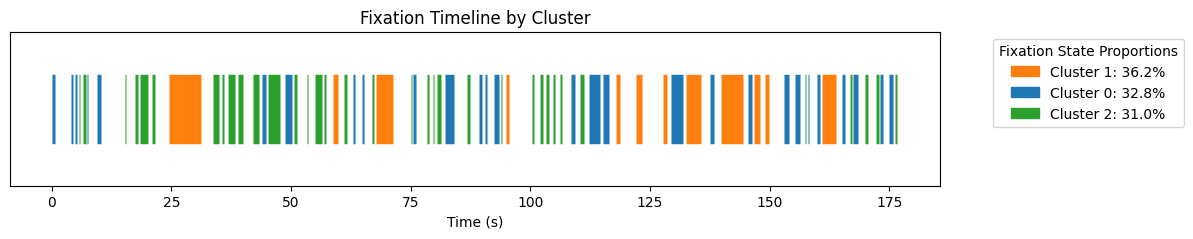

In [144]:
# plot fixation states over time
plt.figure(figsize=(12, 2))
for _, row in fixation_state_summary.iterrows():
    plt.hlines(1, row['start_s'], row['end_s'], colors=f'C{int(row["cluster"])}', linewidth=50)

# Build legend handles
handles = [
    mpatches.Patch(color=f'C{int(row.cluster)}', label=f"Cluster {int(row.cluster)}: {row.percent_time:.1f}%")
    for row in fixation_cluster_percentages.itertuples()
]

plt.legend(handles=handles, title='Fixation State Proportions', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Time (s)")
plt.yticks([])
plt.title("Fixation Timeline by Cluster")
plt.show()

Note that this graph has some empty spaces, this is to be expected because fixations are defined as 'the brief periods when the eyes are relatively still, allowing for detailed visual processing of a specific point or object.' This doesn't happen throughout the entire video, especially during acts of visual search. 

Also since we're trying to understand different behaviors, we have 3 clusters so it is multi-state rather than just categorizing fixated or not fixated (2 clusters). We want to keep these varying levels because we can see shorter and longer fixation differences and since we're not working with attention, we don't need to have such a black and white, binary classification. 

#### Saccades Analysis

In [140]:
saccades_only = timeline[timeline['event_type'] == 'saccade'].copy()

# detect changes in cluster, could indicate state change (e.g. focused, visual search, etc.)
saccades_only['prev_cluster'] = saccades_only['cluster'].shift()
saccades_only['new_state'] = saccades_only['cluster'] != saccades_only['prev_cluster']
saccades_only['state_id'] = saccades_only['new_state'].cumsum()

# summarize states
saccades_state_summary = saccades_only.groupby('state_id').agg({
    'cluster': 'first',
    'time_s': ['min', 'max']
}).reset_index()

# clean up column names
saccades_state_summary.columns = ['state_id', 'cluster', 'start_s', 'end_s']
saccades_state_summary['duration_s'] = saccades_state_summary['end_s'] - saccades_state_summary['start_s']

# print state summary to check it works
print(saccades_state_summary)

     state_id  cluster     start_s       end_s  duration_s
0           1        1    0.605495    0.875743    0.270248
1           2        3    1.816610    2.211989    0.395379
2           3        1    2.397230    2.397230    0.000000
3           4        3    3.157849    3.157849    0.000000
4           5        4    3.588221    3.588221    0.000000
..        ...      ...         ...         ...         ...
216       217        1  173.117099  173.117099    0.000000
217       218        3  173.682724  173.682724    0.000000
218       219        1  174.223223  175.169098    0.945875
219       220        4  175.584481  175.584481    0.000000
220       221        1  176.245097  176.705472    0.460375

[221 rows x 5 columns]


In [145]:
total_time = saccades_state_summary['duration_s'].sum()

# Group by cluster and sum durations
saccades_cluster_durations = saccades_state_summary.groupby('cluster')['duration_s'].sum()

# Calculate percentage
saccades_cluster_percentages = (saccades_cluster_durations / total_time) * 100

# Convert to DataFrame for readability
saccades_cluster_percentages = saccades_cluster_percentages.reset_index()
saccades_cluster_percentages.columns = ['cluster', 'percent_time']
saccades_cluster_percentages = saccades_cluster_percentages.sort_values('percent_time', ascending=False)

# print to check it works
print(saccades_cluster_percentages)

   cluster  percent_time
1        1     65.040092
0        0     24.179469
3        3      6.245881
4        4      3.368603
2        2      1.165955


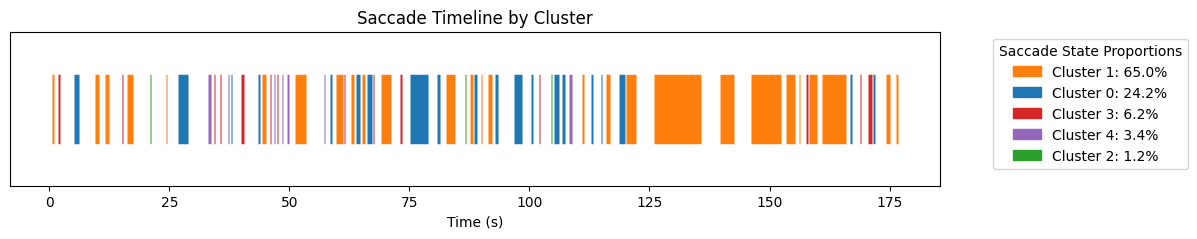

In [146]:
# plot saccades states over time
plt.figure(figsize=(12, 2))
for _, row in saccades_state_summary.iterrows():
    plt.hlines(1, row['start_s'], row['end_s'], colors=f'C{int(row["cluster"])}', linewidth=50)

# Build legend handles
handles = [
    mpatches.Patch(color=f'C{int(row.cluster)}', label=f"Cluster {int(row.cluster)}: {row.percent_time:.1f}%")
    for row in saccades_cluster_percentages.itertuples()
]

plt.legend(handles=handles, title='Saccade State Proportions', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Time (s)")
plt.yticks([])
plt.title("Saccade Timeline by Cluster")
plt.show()

### Overall Analysis

In [151]:
# create time bins (1 second)
time_bin_edges = np.arange(0, timeline['time_s'].max(), 1.0)  # 1-second bins
time_bins = pd.DataFrame({
    'time_start': time_bin_edges[:-1],
    'time_end': time_bin_edges[1:]
})

# reusable function to assign state (aka cluster) to time bins
def assign_state_to_bins(state_df, time_bins, label):
    result = []
    for _, bin_row in time_bins.iterrows():
        mask = (
            (state_df['start_s'] < bin_row['time_end']) &
            (state_df['end_s'] > bin_row['time_start'])
        )
        overlap = state_df[mask]
        if not overlap.empty:
            dominant_cluster = overlap['cluster'].mode().iloc[0]
        else:
            dominant_cluster = np.nan
        result.append(dominant_cluster)
    time_bins[label] = result
    return time_bins

# use above funciton to make summary table
overall_state_summary = time_bins.copy()
overall_state_summary = assign_state_to_bins(gaze_state_summary, overall_state_summary, 'gaze_cluster')
overall_state_summary = assign_state_to_bins(fixation_state_summary, overall_state_summary, 'fixation_cluster')
overall_state_summary = assign_state_to_bins(saccades_state_summary, overall_state_summary, 'saccade_cluster')

# test if its working
print(overall_state_summary)
print(overall_state_summary.isna().sum())

     time_start  time_end  gaze_cluster  fixation_cluster  saccade_cluster
0           0.0       1.0             4               0.0              1.0
1           1.0       2.0             2               0.0              3.0
2           2.0       3.0             2               1.0              1.0
3           3.0       4.0             0               0.0              3.0
4           4.0       5.0             4               0.0              0.0
..          ...       ...           ...               ...              ...
172       172.0     173.0             3               2.0              0.0
173       173.0     174.0             0               0.0              1.0
174       174.0     175.0             0               0.0              1.0
175       175.0     176.0             0               0.0              1.0
176       176.0     177.0             0               0.0              1.0

[177 rows x 5 columns]
time_start           0
time_end             0
gaze_cluster         0
fixatio

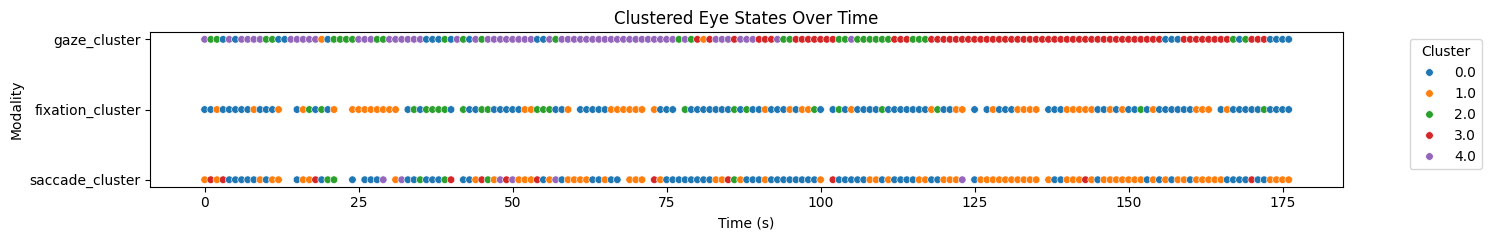

In [ ]:
# now we're plotting the overall state summary
melted = overall_state_summary.melt(id_vars=['time_start'], 
                                     value_vars=['gaze_cluster', 'fixation_cluster', 'saccade_cluster'])

plt.figure(figsize=(15, 2.5))
sns.scatterplot(data=melted, x='time_start', y='variable', hue='value', palette='tab10', s=30)

plt.xlabel("Time (s)")
plt.ylabel("Modality")
plt.title("Clustered Eye States Over Time")
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [161]:
# now we're gonna combine everything to understand if there are any patterns in the clusters across modalities
# this will tell us if we can detect certain states from combined data
combo_counts = overall_state_summary[['gaze_cluster', 'fixation_cluster', 'saccade_cluster']].value_counts().reset_index()
combo_counts.columns = ['gaze', 'fixation', 'saccade', 'count']
combo_counts = combo_counts.sort_values('count', ascending=False)
print(combo_counts.head(10))

   gaze  fixation  saccade  count
0     3       1.0      1.0     17
1     3       0.0      0.0     16
2     3       0.0      1.0     14
3     4       0.0      1.0     12
4     4       0.0      0.0     12
5     2       0.0      0.0      9
6     4       1.0      1.0      8
8     4       1.0      0.0      6
9     2       0.0      1.0      6
7     0       0.0      1.0      6


In [165]:
cluster_cols = ['gaze_cluster', 'fixation_cluster', 'saccade_cluster']

# fill NaNs, using -1 to represent "no data")
X = overall_state_summary[cluster_cols].fillna(-1)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [168]:
# meta GMM
gmm = GaussianMixture(n_components=5, random_state=42)
meta_state_labels = gmm.fit_predict(X_scaled)

# assign to the DataFrame
overall_state_summary['meta_state'] = meta_state_labels

# check it works
print(overall_state_summary['meta_state'].value_counts())

meta_state
2    93
0    35
3    28
1    13
4     8
Name: count, dtype: int64


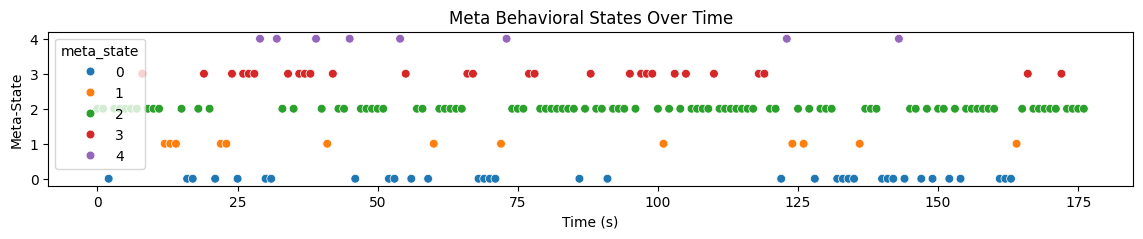

In [173]:
plt.figure(figsize=(14, 2))
sns.scatterplot(data=overall_state_summary, x='time_start', y='meta_state', hue='meta_state', palette='tab10', s=40)
plt.title("Meta Behavioral States Over Time")
plt.xlabel("Time (s)")
plt.ylabel("Meta-State")
plt.yticks(sorted(overall_state_summary['meta_state'].unique()))
plt.show()